['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


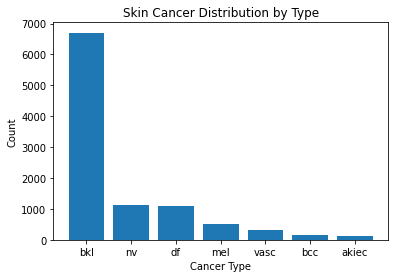

C:\Users\S k mishra\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


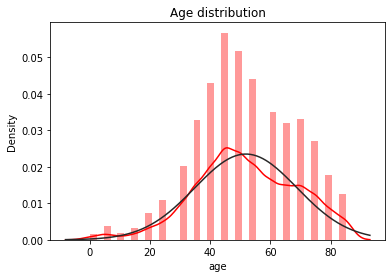

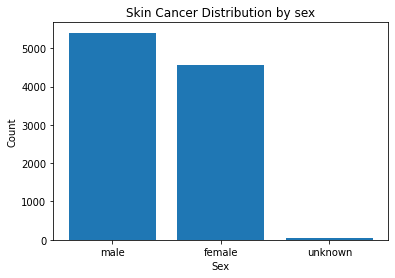

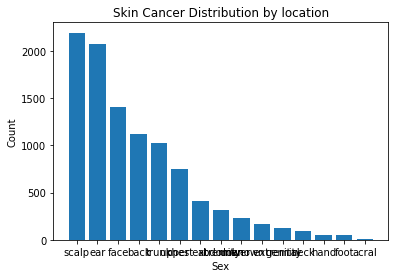

In [8]:
#Special Assignment on Skin Cancer detection using CNN

#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix
import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical,normalize,plot_model
from scipy import stats
from sklearn.preprocessing import LabelEncoder
np.random.seed(12)
size = 32
input_shape = [size,size,3]

#Reading csv file
skin_df = pd.read_csv('data/HAM10000/HAM10000_metadata.csv')


# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))
skin_df['label'] = le.transform(skin_df["dx"]) 


#Visualization of Data Distribution

#Visualizing by Skin Cancer type
plt.bar(skin_df['dx'].unique(),skin_df['dx'].value_counts())
plt.ylabel('Count')
plt.xlabel('Cancer Type')
plt.title('Skin Cancer Distribution by Type')
plt.savefig('Skin Cancer Distribution by Type.png',dpi = 300)
plt.show()

#Visualizing by Skin Cancer patient age
ax = plt.figure()
sample_age = skin_df[pd.notnull(skin_df['age'])] #Creates a dataframe which contains dataset where age is not null/present
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
plt.title('Age distribution')
plt.savefig('Skin Cancer Distribution by Age.png',dpi = 300)

#Visualizing by Skin Cancer patient sex
plt.figure()
plt.bar(skin_df['sex'].unique(),skin_df['sex'].value_counts())
plt.ylabel('Count')
plt.xlabel('Sex')
plt.title('Skin Cancer Distribution by sex')
plt.savefig('Skin Cancer Distribution by sex.png',dpi = 300)
plt.show()

#Visualizing by location of cancer in patient
plt.figure()
plt.bar(skin_df['localization'].unique(),skin_df['localization'].value_counts())
plt.ylabel('Count')
plt.xlabel('Sex')
plt.title('Skin Cancer Distribution by location')
plt.savefig('Skin Cancer Distribution by location.png',dpi = 300)
plt.show()

In [2]:
#As we can see by the distribution curves dataset is highly biased towards bkl
#If we apply machine leraning model on this dataset our acuracy will be less
#So we do resampling of our data 
#Each sample has size of 500 images
from sklearn.utils import resample
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

samples_size=500 
df_0_balanced = resample(df_0, replace=True, n_samples=samples_size, random_state=12) 
df_1_balanced = resample(df_1, replace=True, n_samples=samples_size, random_state=12) 
df_2_balanced = resample(df_2, replace=True, n_samples=samples_size, random_state=12)
df_3_balanced = resample(df_3, replace=True, n_samples=samples_size, random_state=12)
df_4_balanced = resample(df_4, replace=True, n_samples=samples_size, random_state=12)
df_5_balanced = resample(df_5, replace=True, n_samples=samples_size, random_state=12)
df_6_balanced = resample(df_6, replace=True, n_samples=samples_size, random_state=12)

skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])
print(skin_df_balanced)

        lesion_id      image_id     dx    dx_type   age     sex  \
9842  HAM_0004609  ISIC_0030785  akiec      histo  75.0    male   
9940  HAM_0004297  ISIC_0027550  akiec      histo  65.0  female   
9928  HAM_0006560  ISIC_0028063  akiec      histo  50.0    male   
9817  HAM_0000552  ISIC_0028872  akiec      histo  55.0    male   
9946  HAM_0007303  ISIC_0026457  akiec      histo  75.0  female   
...           ...           ...    ...        ...   ...     ...   
2353  HAM_0006156  ISIC_0027903   vasc      histo  45.0  female   
2454  HAM_0001860  ISIC_0027665   vasc  consensus  50.0    male   
2374  HAM_0005989  ISIC_0033565   vasc      histo  25.0  female   
2446  HAM_0002639  ISIC_0025249   vasc  consensus  30.0  female   
2358  HAM_0004776  ISIC_0032867   vasc      histo  45.0  female   

         localization  label  
9842             back      0  
9940  upper extremity      0  
9928             face      0  
9817  lower extremity      0  
9946  lower extremity      0  
...      

In [3]:
#Getting all the images in our dataframe
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('data/HAM10000/', '*', '*.jpg'))}
skin_df_balanced['path'] = skin_df_balanced['image_id'].map(image_path.get)
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((size,size))))

In [4]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scaling  values from 0-1.
Y=skin_df_balanced['label']  #Assigning label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Onehot Encoding
#Splitting to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.10, random_state=42)

In [5]:
model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(size, size, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 256)       7168      
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 256)      1024      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       295040    
                                                                 
 batch_normalization_1 (Batc  (None, 13, 13, 128)      5

In [6]:
batch_size = 16
epochs = 50

h = model.fit( x_train, y_train, epochs=epochs, batch_size = batch_size, validation_data=(x_test, y_test), verbose=1)
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])


Epoch 1/50
197/197 [==============================] - 26s 129ms/step - loss: 2.0923 - acc: 0.3435 - val_loss: 2.1160 - val_acc: 0.1857
Epoch 2/50
197/197 [==============================] - 27s 138ms/step - loss: 1.5637 - acc: 0.4444 - val_loss: 1.8998 - val_acc: 0.1857
Epoch 3/50
197/197 [==============================] - 26s 131ms/step - loss: 1.3624 - acc: 0.5022 - val_loss: 1.6262 - val_acc: 0.3514
Epoch 4/50
197/197 [==============================] - 25s 129ms/step - loss: 1.2829 - acc: 0.5340 - val_loss: 1.5908 - val_acc: 0.4114
Epoch 5/50
197/197 [==============================] - 26s 129ms/step - loss: 1.1926 - acc: 0.5448 - val_loss: 5.9880 - val_acc: 0.2143
Epoch 6/50
197/197 [==============================] - 25s 128ms/step - loss: 1.1157 - acc: 0.5949 - val_loss: 1.2740 - val_acc: 0.5400
Epoch 7/50
197/197 [==============================] - 26s 130ms/step - loss: 1.0478 - acc: 0.6111 - val_loss: 2.7401 - val_acc: 0.2171
Epoch 8/50
197/197 [==============================] - 2

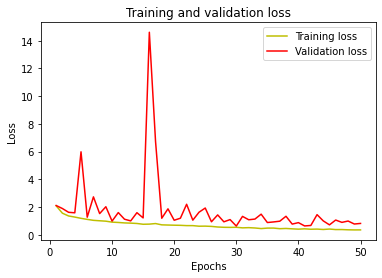

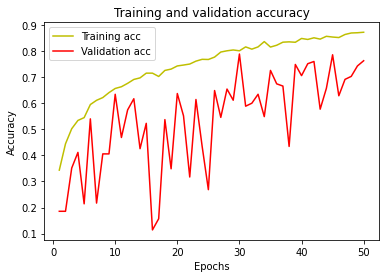

              precision    recall  f1-score   support

           0       0.82      0.69      0.75        65
           1       0.79      0.71      0.75        59
           2       0.51      0.80      0.63        45
           3       0.98      0.94      0.96        50
           4       0.60      0.69      0.64        39
           5       0.76      0.72      0.74        40
           6       1.00      0.79      0.88        52

    accuracy                           0.76       350
   macro avg       0.78      0.76      0.76       350
weighted avg       0.79      0.76      0.77       350



In [7]:
#plot the training and validation accuracy and loss at each epoch
loss = h.history['loss']
val_loss = h.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Loss.png',dpi = 300)
plt.show()


acc = h.history['acc']
val_acc = h.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Accuracy.png',dpi = 300)
plt.show()


# Prediction on test data
y_pred = model.predict(x_test)
y_pred_class = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred_class))